# Training in Brax

Once an environment is created in brax, we can quickly train it using brax's built-in training algorithms. Let's try it out!

In [1]:
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output


import brax


import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
from src.env.PendulumPPO import InvertedPendulum


First let's pick an environment and a backend to train an agent in.

Recall from the [Brax Basics](https://github.com/google/brax/blob/main/notebooks/basics.ipynb) colab, that the backend specifies which physics engine to use, each with different trade-offs between physical realism and training throughput/speed. The engines generally decrease in physical realism but increase in speed in the following order: `generalized`,  `positional`, then `spring`.


In [2]:
#@title Load Env { run: "auto" }
key = jax.random.PRNGKey(1)
env_name = 'inverted_pendulum'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = InvertedPendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))


# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/agents/es/train.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/agents/apg/train.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/agents/ars/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

# Training

Let's train the Ant policy using the `generalized` backend with PPO.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
ticker.EngFormatter.ENG_PREFIXES.update({9:"B"}) # For cleaner formatting


from scipy.stats import trim_mean, bootstrap

sns.set()

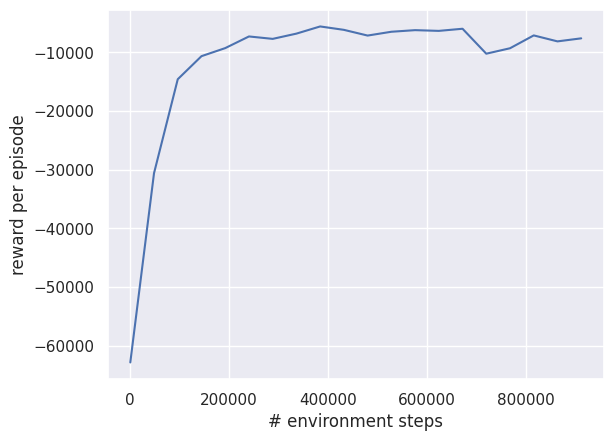

In [4]:
#@title Training
import pandas as pd

# We determined some reasonable hyperparameters offline and share them here.



#max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'humanoid': 13000, 'humanoidstandup': 75_000, 'reacher': 5, 'walker2d': 5000, 'pusher': 0}[env_name]
#min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    #plt.xlim([0, train_fn.keywords['num_timesteps']])
    #plt.ylim([min_y, max_y])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()


    data = {'epoch': xdata, f'{i}': ydata}
    new_data = pd.DataFrame(data)
    file_path='ppodata.txt'
    if os.path.exists(file_path):
      existing_data = pd.read_csv(file_path)
      if 'epoch' not in existing_data.columns:
          existing_data['epoch'] = new_data['epoch']
      if f'{i}' in existing_data.columns:
          existing_data = existing_data.drop(columns=[f'{i}'])
      existing_data = pd.merge(existing_data, new_data, on='epoch', how='outer')
    else:
      existing_data = new_data

    existing_data.to_csv(file_path, index=False)
for i in range(0,25):
  train_fn = {
  'inverted_pendulum': functools.partial(ppo.train, num_timesteps=800_000, num_evals=20, reward_scaling=10, episode_length=50, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=200, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=200, batch_size=16, seed=i)
  }[env_name]
  xdata, ydata = [], []
        #@title Load Env { run: "auto" }
  state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=i))
  make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)



The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [5]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [6]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

yes=html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout)
with open("datappo.html", "w") as file:
    file.write(yes)

🙌 See you soon!